# Sistema de recomendação de filmes 

In [1]:
# Versão do python

from platform import python_version
print('Versão python neste Jupyter Notebook:', python_version())

Versão python neste Jupyter Notebook: 3.8.8


In [2]:
# Importação das bibliotecas 

import pandas as pd # Pandas carregamento csv
import numpy as np # Numpy para carregamento cálculos em arrays multidimensionais

# Machine learning
from fuzzywuzzy import process
from scipy.sparse import csr_matrix

# Visualização de dados
import seaborn as sns
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

# Carregar as versões das bibliotecas
import watermark

# Warnings retirar alertas 
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Loading BokehJS ...

In [3]:
# Versões das bibliotecas

%reload_ext watermark
%watermark -a "Versões das bibliotecas" --iversions

Author: Versões das bibliotecas

pandas    : 1.2.4
numpy     : 1.20.1
plotly    : 5.6.0
fuzzywuzzy: 0.18.0
seaborn   : 0.11.1
watermark : 2.3.0
matplotlib: 3.3.4



In [4]:
# Configuração para os gráficos largura e layout dos graficos

plt.style.use('seaborn-darkgrid')
sns.set_style("whitegrid")

In [5]:
# Dataset 
df_movie = pd.read_csv("movie.csv")
df_rating = pd.read_csv("rating.csv")
df_tag = pd.read_csv("tag.csv")

In [6]:
# Exibindo os 5 primeiros dados
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Exibindo os 5 primeiros ultimos dados
df_movie.tail()

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


In [8]:
# Info dados
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [9]:
# Tipos dos dados
df_movie.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [10]:
# Total de colunas e linhas 

print("Números de linhas: {}" .format(df_movie.shape[0]))
print("Números de colunas: {}" .format(df_movie.shape[1]))

Números de linhas: 27278
Números de colunas: 3


In [11]:
# Titulo dos filmes
df_movie.title

0                          Toy Story (1995)
1                            Jumanji (1995)
2                   Grumpier Old Men (1995)
3                  Waiting to Exhale (1995)
4        Father of the Bride Part II (1995)
                        ...                
27273          Kein Bund für's Leben (2007)
27274         Feuer, Eis & Dosenbier (2002)
27275                    The Pirates (2014)
27276                   Rentun Ruusu (2001)
27277                      Innocence (2014)
Name: title, Length: 27278, dtype: object

In [12]:
# Contagem dos títulos
df_movie.title.count()

27278

In [13]:
# Limpando o ano da coluna de título e gerando coluna ano
df_movie["year"] = df_movie.title.str.extract('(\(\d\d\d\d\))',expand=False)

# Removendo os parênteses
df_movie["year"] = df_movie.year.str.extract('(\d\d\d\d)',expand=False)

# Removendo os anos da coluna 'título'
df_movie['title'] = df_movie.title.str.replace('(\(\d\d\d\d\))', '')

# Aplicando a função strip para se livrar de quaisquer caracteres de espaço em branco finais que possam ter aparecido
df_movie['title'] = df_movie['title'].str.strip()
df_movie.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [14]:
# Agora junte os dois conjuntos de dados, pois exigimos o ID do usuário.
# A classificação do filme e o nome de todos os filmes para nosso modelo.

df = df_movie.join(df_rating, lsuffix='N', rsuffix='K')
df

,movieIdN,title,genres,year,userId,movieIdK,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,2,3.5,2005-04-02 23:53:47
1,2,Jumanji,Adventure|Children|Fantasy,1995,1,29,3.5,2005-04-02 23:31:16
2,3,Grumpier Old Men,Comedy|Romance,1995,1,32,3.5,2005-04-02 23:33:39
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,1,47,3.5,2005-04-02 23:32:07
4,5,Father of the Bride Part II,Comedy,1995,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben,Comedy,2007,211,527,5.0,2006-10-08 18:35:17
27274,131256,"Feuer, Eis & Dosenbier",Comedy,2002,211,589,3.5,2006-10-08 18:37:28
27275,131258,The Pirates,Adventure,2014,211,593,4.0,2006-10-08 18:38:01
27276,131260,Rentun Ruusu,(no genres listed),2001,211,594,4.5,2006-10-08 18:31:34


# Data Visualization

In [15]:
df_rating.groupby('movieId').rating.mean()
print("Média notas dos filmes", df_rating)

Média notas dos filmes           userId  movieId  rating            timestamp
0              1        2     3.5  2005-04-02 23:53:47
1              1       29     3.5  2005-04-02 23:31:16
2              1       32     3.5  2005-04-02 23:33:39
3              1       47     3.5  2005-04-02 23:32:07
4              1       50     3.5  2005-04-02 23:29:40
...          ...      ...     ...                  ...
20000258  138493    68954     4.5  2009-11-13 15:42:00
20000259  138493    69526     4.5  2009-12-03 18:31:48
20000260  138493    69644     3.0  2009-12-07 18:10:57
20000261  138493    70286     5.0  2009-11-13 15:42:24
20000262  138493    71619     2.5  2009-10-17 20:25:36

[20000263 rows x 4 columns]


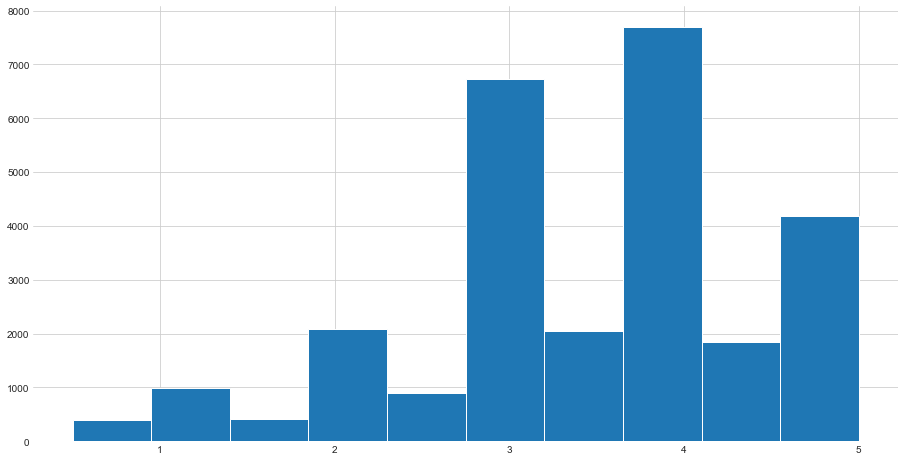

In [16]:
plt.figure(figsize=(15.5, 8))

plt.hist(df["rating"]);

Text(0, 0.5, 'Total')

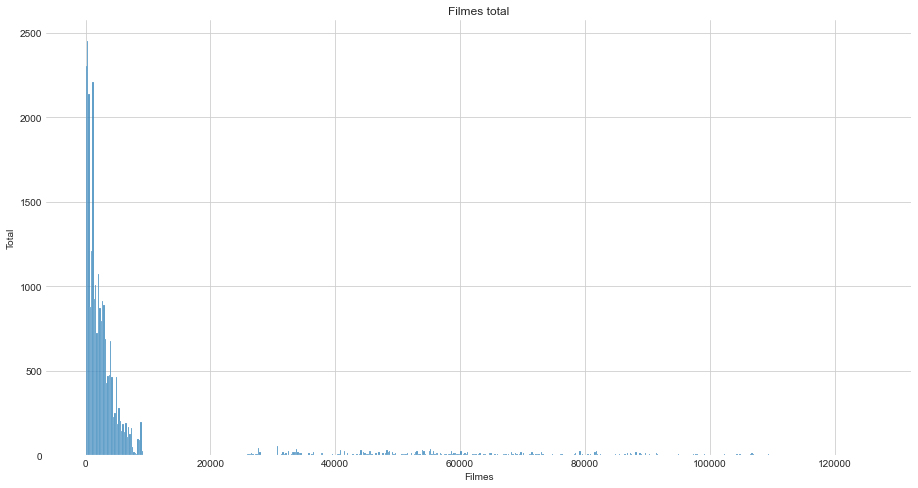

In [19]:
plt.figure(figsize=(15.5, 8))

plt.title("Filmes total")
sns.histplot(df["movieIdK"])
plt.xlabel("Filmes")
plt.ylabel("Total")

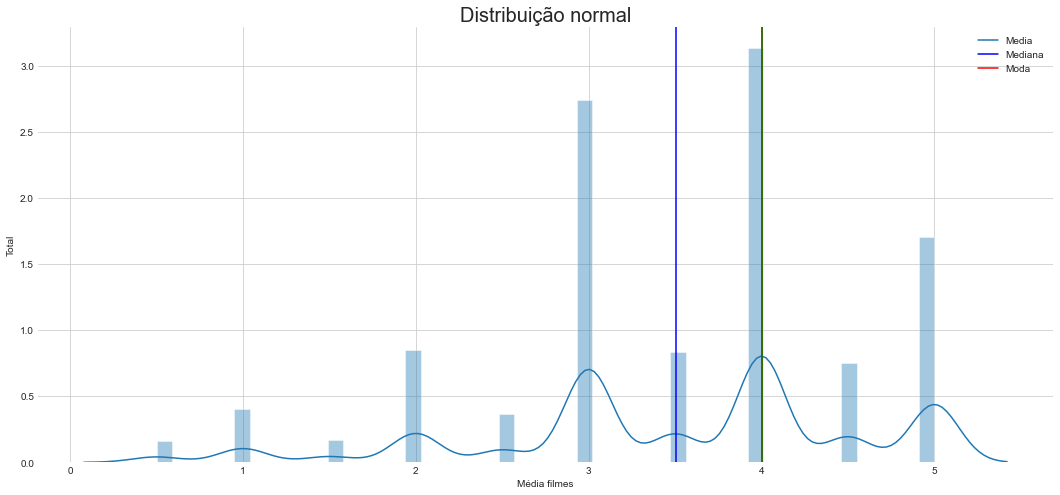

In [20]:
# Gráfico distribuição normal
plt.figure(figsize=(18.2, 8))

ax = sns.distplot(df['rating']);
plt.title("Distribuição normal", fontsize=20)
plt.xlabel("Média filmes")
plt.ylabel("Total")
plt.axvline(df['rating'].mean(), color='b')
plt.axvline(df['rating'].median(), color='r')
plt.axvline(df['rating'].mode()[0], color='g');
plt.legend(["Media", "Mediana", "Moda"])
plt.show()

In [22]:
# Cálculo da média 

media_filmes = df[['timestamp', 'rating']].groupby('timestamp').mean()
media_filmes_2 = df[["timestamp", "rating"]].groupby('timestamp').mean()

print("Média de média filmes", media_filmes)
print()
print("Média de média filmes 2", media_filmes_2)

Média de média filmes                      rating
timestamp                  
1996-04-23 17:14:51     3.2
1996-04-23 17:15:21     3.0
1996-04-23 17:15:45     4.2
1996-04-23 17:16:07     3.5
1996-04-23 17:16:31     2.0
...                     ...
2015-03-19 14:19:31     3.0
2015-03-19 14:21:45     5.0
2015-03-19 14:24:01     5.0
2015-03-19 14:26:23     5.0
2015-03-29 16:19:58     2.0

[19212 rows x 1 columns]

Média de média filmes 2                      rating
timestamp                  
1996-04-23 17:14:51     3.2
1996-04-23 17:15:21     3.0
1996-04-23 17:15:45     4.2
1996-04-23 17:16:07     3.5
1996-04-23 17:16:31     2.0
...                     ...
2015-03-19 14:19:31     3.0
2015-03-19 14:21:45     5.0
2015-03-19 14:24:01     5.0
2015-03-19 14:26:23     5.0
2015-03-29 16:19:58     2.0

[19212 rows x 1 columns]


**Nuvem de palavras - Gêneros de filme**

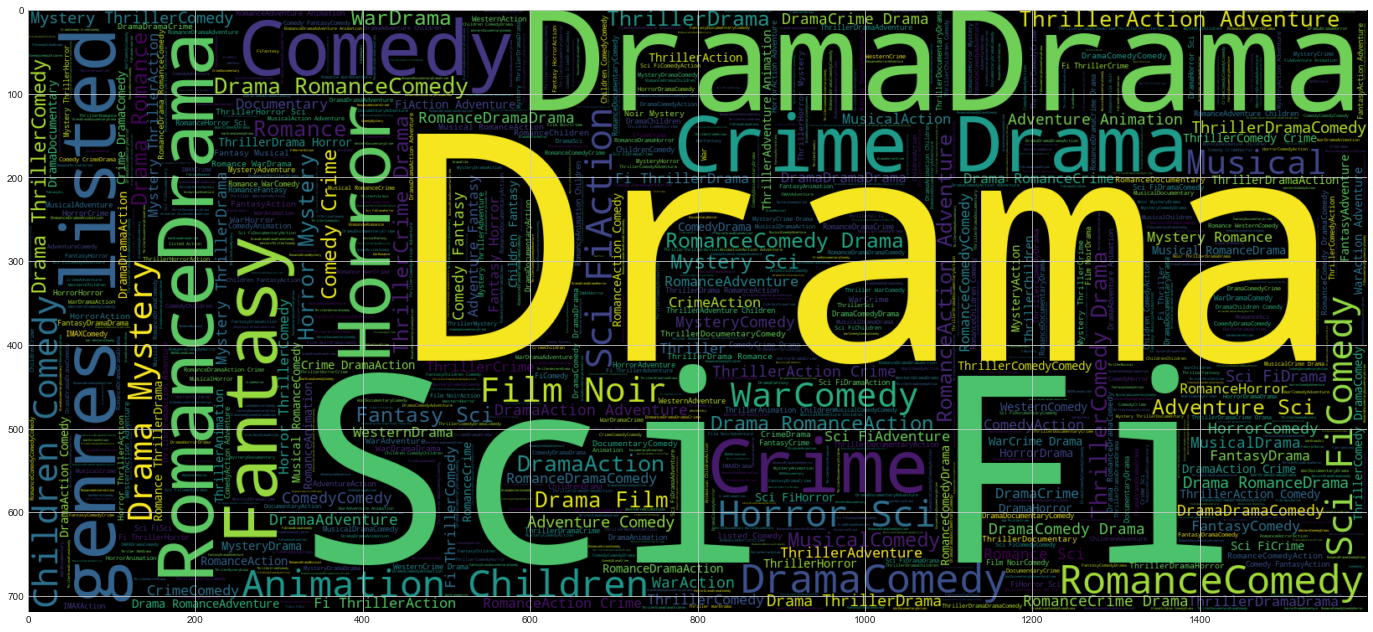

In [23]:
import warnings   
from wordcloud import WordCloud
from termcolor import cprint

plt.figure(figsize=(24,20))

world_cloud_postive = WordCloud(min_font_size = 3,
                                max_words = 3200,
                                width = 1600,
                                height = 720).generate("".join(df.genres))

plt.imshow(world_cloud_postive,interpolation='bilinear')

**Nuvem de palavras - Gêneros de títulos de filmes**

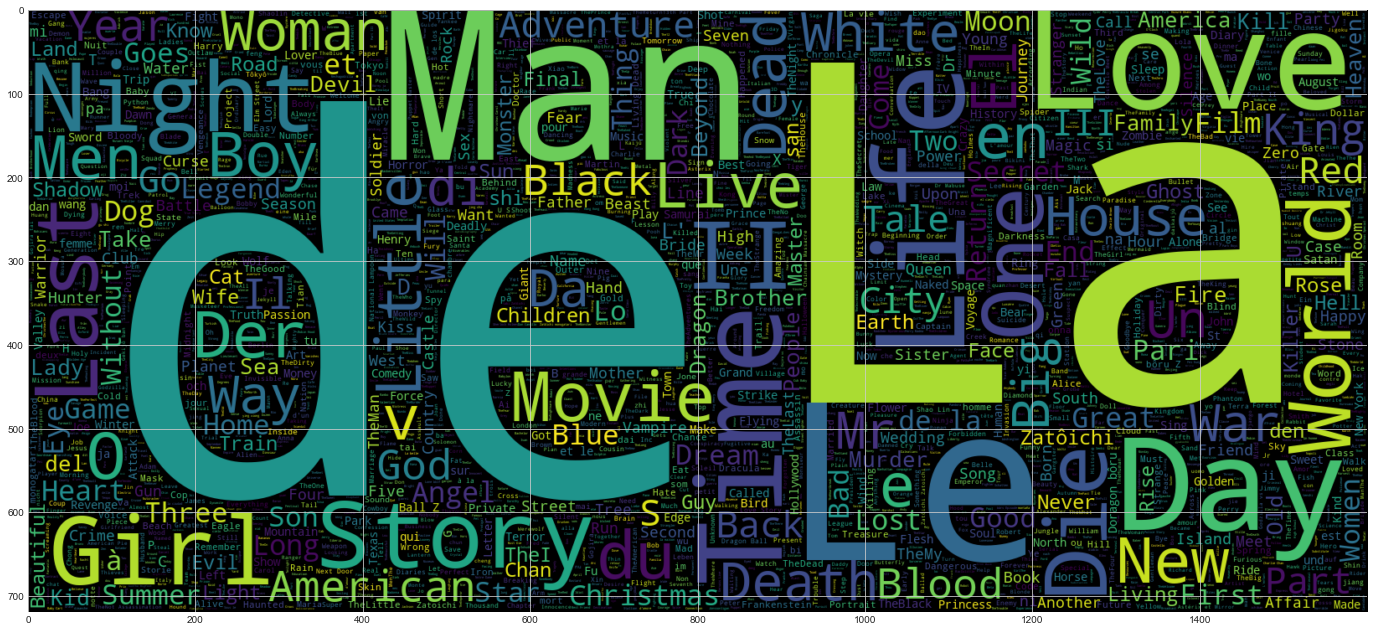

In [24]:
plt.figure(figsize=(24,20))

world_cloud_postive = WordCloud(min_font_size = 3, 
                                max_words = 3200, 
                                width = 1600, 
                                height = 720).generate("".join(df.title))

plt.imshow(world_cloud_postive,interpolation='bilinear')

# Limpeza dos dados

In [25]:
# Removendo as colunas desnecessárias

df = df.drop(['movieIdK','genres','year','timestamp'],axis=1)
df.head()

,movieIdN,title,userId,rating
0,1,Toy Story,1,3.5
1,2,Jumanji,1,3.5
2,3,Grumpier Old Men,1,3.5
3,4,Waiting to Exhale,1,3.5
4,5,Father of the Bride Part II,1,3.5


In [26]:
# Novo dataframe
# Haverá muito valor nan em nosso novo dataframe, pois é altamente improvável que nossos usuários tenham visto quase todos os filmes.

usuarios_filmes = df.pivot(index = 'movieIdN', 
                           columns = 'userId',
                           values = 'rating').fillna(0)

matrix_usuarios_filmes=csr_matrix(usuarios_filmes.values)
print(matrix_usuarios_filmes)

  (0, 0)	3.5
  (1, 0)	3.5
  (2, 0)	3.5
  (3, 0)	3.5
  (4, 0)	3.5
  (5, 0)	3.5
  (6, 0)	4.0
  (7, 0)	4.0
  (8, 0)	4.0
  (9, 0)	4.0
  (10, 0)	4.0
  (11, 0)	4.0
  (12, 0)	4.0
  (13, 0)	3.5
  (14, 0)	3.5
  (15, 0)	4.0
  (16, 0)	3.5
  (17, 0)	3.5
  (18, 0)	3.0
  (19, 0)	3.5
  (20, 0)	3.5
  (21, 0)	3.5
  (22, 0)	4.0
  (23, 0)	4.0
  (24, 0)	3.5
  :	:
  (27253, 209)	3.0
  (27254, 209)	4.0
  (27255, 209)	5.0
  (27256, 209)	4.0
  (27257, 209)	4.0
  (27258, 209)	4.0
  (27259, 209)	2.0
  (27260, 210)	3.0
  (27261, 210)	3.0
  (27262, 210)	3.0
  (27263, 210)	4.0
  (27264, 210)	4.0
  (27265, 210)	5.0
  (27266, 210)	3.0
  (27267, 210)	4.0
  (27268, 210)	5.0
  (27269, 210)	4.0
  (27270, 210)	4.0
  (27271, 210)	5.0
  (27272, 210)	3.0
  (27273, 210)	5.0
  (27274, 210)	3.5
  (27275, 210)	4.0
  (27276, 210)	4.5
  (27277, 210)	4.0


# Modelo machine learning - KNN

- NearestNeighbors para computar semelhanças entre as classificações de outros usuários no mesmo filme. Existem diferentes métricas em knn como distância euclidiana, distância de Manhattan, distância de Minkowski, semelhança de cosseno. Neste vamos usar semelhança de cosseno como nossa métrica.

- Função de recomendação.Nesta eu usei uma função da biblioteca chamada fuzzywuzzy ,ela resolve o problema de encontrar os filmes com erros ortográficos e independente de sua letra em minúscula ou maiúscula.

In [27]:
# Modelo machine learning 
# Modelo KNN para a recomendação de filme

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = "cosine", 
                             algorithm = "brute", 
                             n_neighbors = 10)

model_knn.fit(matrix_usuarios_filmes)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [28]:
def recomendacao_filme(movie_name, data,model, n_recommendations):
    model.fit(data)
    idx = process.extractOne(movie_name, df['title'])[2]
    
    print('Filme selecionado:-',df['title'][idx], 'Index: ',idx)
    print()
    print('Procurando recomendações.....')
    print()
    print("Fim da recomendação")
    
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    
    for i in indices:
        print(df['title'][i].where(i!=idx))

**Recomendação dos filmes selecionados**

In [29]:
recomendacao_filme('Pirates of the caribbean curse of the black pearl', 
                   matrix_usuarios_filmes, 
                   model_knn, 5)

Filme selecionado:- Pirates of the Caribbean: The Curse of the Black Pearl Index:  6429

Procurando recomendações.....

Fim da recomendação
6835    Master and Commander: The Far Side of the World
6837                                     Big Empty, The
6833                      My Architect: A Son's Journey
6834                       Looney Tunes: Back in Action
6831                   Love Forbidden (Défense d'aimer)
Name: title, dtype: object


In [30]:
recomendacao_filme('Innocence', 
                   matrix_usuarios_filmes, 
                   model_knn, 15)

Filme selecionado:- Innocence Index:  4635

Procurando recomendações.....

Fim da recomendação
4659                                     Wish Upon a Star
4661                                            Rock Star
4651                                       Speedway Junky
4652                                             3 Ninjas
4653                                   3 Ninjas Kick Back
4654                                  3 Ninjas Knuckle Up
4655                                          Hunter, The
4656                                               Maniac
4657                                                 Vamp
4658                                      Wicker Man, The
4649                                                    O
4660                                       Musketeer, The
4670    Our Lady of the Assassins (Virgen de los sicar...
4647                                        Tortilla Soup
4666                                               Djomeh
Name: title, dtype: object


In [31]:
recomendacao_filme('Terminator', 
                   matrix_usuarios_filmes, 
                   model_knn, 15)

Filme selecionado:- Terminator 2: Judgment Day Index:  583

Procurando recomendações.....

Fim da recomendação
724                                              Twister
722                             Getting Away With Murder
729                                              Thinner
728                  Ghost in the Shell (Kôkaku kidôtai)
727                               Honey Moon (Honigmond)
726                                            Garçu, Le
725                                            Barb Wire
731                                  Brothers in Trouble
723                  Cemetery Man (Dellamorte Dellamore)
718                                             Low Life
719                                   Heaven's Prisoners
717    Institute Benjamenta, or This Dream People Cal...
732                      Wallace & Gromit: A Close Shave
720                                    Original Gangstas
721                                            Rock, The
Name: title, dtype: object


In [32]:
recomendacao_filme('jumanji', 
                   matrix_usuarios_filmes, 
                   model_knn, 15)

Filme selecionado:- Jumanji Index:  1

Procurando recomendações.....

Fim da recomendação
121               Chungking Express (Chung Hing sam lam)
122              Star Maker, The (Uomo delle stelle, L')
113    Happiness Is in the Field (Bonheur est dans le...
114                                Anne Frank Remembered
115                       Young Poisoner's Handbook, The
116                                         If Lucy Fell
117                              Steal Big, Steal Little
118                                         Race the Sun
119                             Boys of St. Vincent, The
120                                            Boomerang
111                                     Before and After
126                                       Jupiter's Wife
128                                               Angela
130                                                 Jade
129                                    Frankie Starlight
Name: title, dtype: object
